### IMPORT LIBRARIES

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import skimage.io
import tensorflow 
import tqdm
import glob

from tqdm import tqdm 

from skimage.io import imread, imshow
# from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

### IMPORT DATASET 

> `TRAINING IMAGES`

In [3]:
train_o = glob.glob('../input/waste-classification-data/DATASET/TRAIN/O/*.jpg')
a = len(train_o)

In [4]:
train_r = glob.glob('../input/waste-classification-data/DATASET/TRAIN/R/*.jpg')
b = len(train_r)

In [5]:
# Total training images 

print("Nos of training samples: {}".format(a+b))

Nos of training samples: 22564


> `DATA AUGMENTATION`

In [6]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/waste-classification-data/DATASET/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128, 
                                                   subset = 'training')

Found 18052 images belonging to 2 classes.


In [8]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/waste-classification-data/DATASET/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128, 
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


In [9]:
# Class Indices 

train_dataset.class_indices

{'O': 0, 'R': 1}

100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


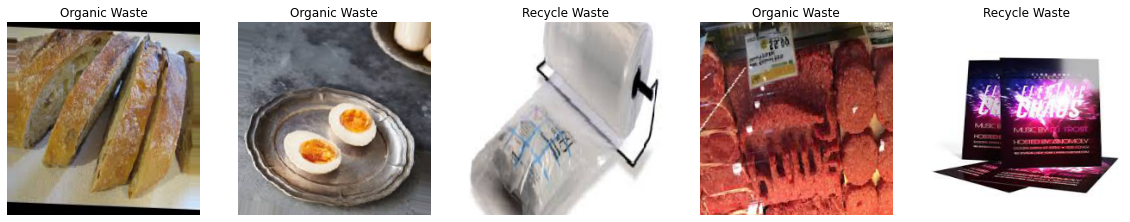

In [10]:
# Viewing Images

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('Recycle Waste')
    else:
        ax[i].set_title('Organic Waste')

### MODEL BUILDING

In [11]:
# Defining Model

base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

58892288/58889256 [==============================] - 0s 0us/step


In [12]:
# Freezing Layers 

for layer in base_model.layers:
    layer.trainable=False

In [13]:
# Summary

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# Defining Layers

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [15]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0

In [16]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [17]:
# Defining Callbacks

filepath = './model.h5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

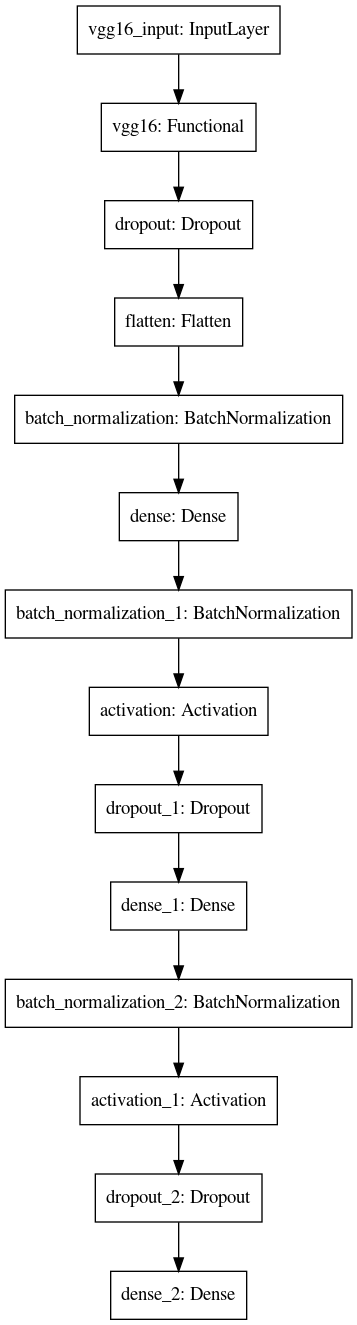

In [18]:
plot_model(model, to_file='model.png')

In [19]:
# Model Fitting 

model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 15,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/15
142/142 [==============================] - ETA: 0s - loss: 0.3439 - auc: 0.9303
Epoch 00001: val_auc improved from -inf to 0.95181, saving model to ./model.h5
142/142 [==============================] - 317s 2s/step - loss: 0.3439 - auc: 0.9303 - val_loss: 0.2880 - val_auc: 0.9518
Epoch 2/15
142/142 [==============================] - ETA: 0s - loss: 0.2692 - auc: 0.9553
Epoch 00002: val_auc did not improve from 0.95181
142/142 [==============================] - 234s 2s/step - loss: 0.2692 - auc: 0.9553 - val_loss: 0.3429 - val_auc: 0.9283
Epoch 3/15
142/142 [==============================] - ETA: 0s - loss: 0.2434 - auc: 0.9633
Epoch 00003: val_auc did not improve from 0.95181
142/142 [==============================] - 229s 2s/step - loss: 0.2434 - auc: 0.9633 - val_loss: 0.3294 - val_auc: 0.9380
Epoch 4/15
142/142 [==============================] - ETA: 0s - loss: 0.2352 - auc: 0.9658
Epoch 00004: val_auc did not improve from 0.95181
142/142 [==============================] 

### MODEL EVALUATION

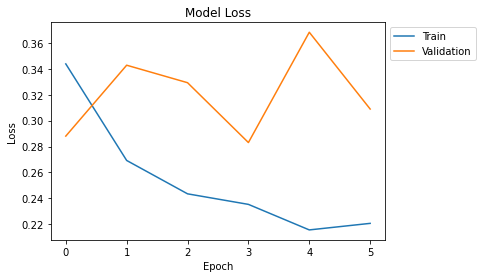

In [20]:
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

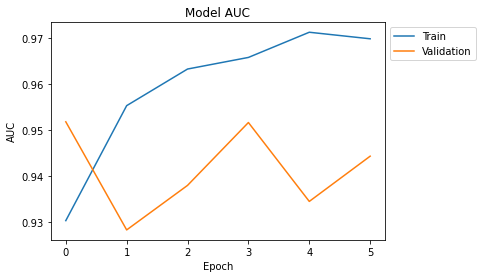

In [21]:
# Summarize models auc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [22]:
# Test Data 
test_data = test_datagen.flow_from_directory(directory = '../input/waste-classification-data/DATASET/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 2513 images belonging to 2 classes.


In [23]:
# Evaluating Loss and AUC - Test Data 

model.evaluate(test_data)

20/20 [==============================] - 17s 828ms/step - loss: 0.3491 - auc: 0.9408


[0.3490825593471527, 0.9408496022224426]

ORGANIC


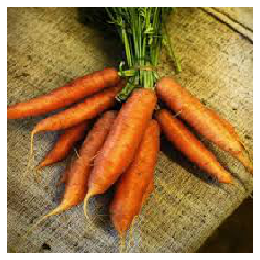

In [27]:
# Test Case:1 - ORGANIC

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('../input/waste-classification-data/DATASET/TEST/O/O_12654.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("RECYCLABLE")
else:
    print("ORGANIC")

ORGANIC


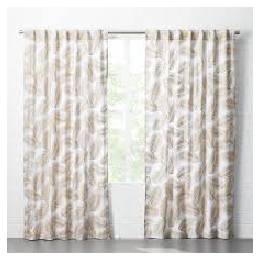

In [28]:
# Test Case:2 - RECYCLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('../input/waste-classification-data/DATASET/TEST/R/R_10011.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("RECYCLABLE")
else:
    print("ORGANIC")

In [30]:
train_dataset.class_indices

{'O': 0, 'R': 1}

### CONCLUSION

> `1. We were able to classify images properly having accuracy of 97.00% in training dataset.`

> `2. We acheived an accuracy of 95.60% on validation data and 94.98% accuracy on test accuracy.`